In [562]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Support Vector Machines (SVM) and Confusion Matrix

- age
- sex
- chest pain type (4 values)
- RestBP: resting blood pressure
- Chol: serum cholestoral in mg/dl
- Fbs: fasting blood sugar > 120 mg/dl
- RestECG: resting electrocardiographic results (values 0,1,2)
- MaxHR: maximum heart rate achieved
- ExAng: exercise induced angina
- Oldpeak: ST depression induced by exercise relative to rest
- Slope: the slope of the peak exercise ST segment
- Ca: number of major vessels (0-3) colored by flourosopy
- thal: thalassemia 0 = normal; 1 = fixed defect; 2 = reversable defect

The target is AHD (aquired heart diseases). 

In [563]:
df = pd.read_csv('./heart.txt')
df.columns
df['ChestPain'].unique()
df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,No


## EDA

In [564]:
df.isna().sum()

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         0
AHD          0
dtype: int64

<Axes: xlabel='ChestPain'>

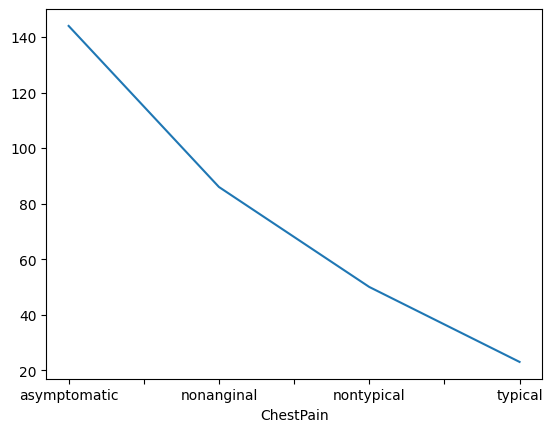

In [565]:
df['ChestPain'].value_counts().plot()

In [566]:
df['Slope'].value_counts()

Slope
1    142
2    140
3     21
Name: count, dtype: int64

In [567]:
df.groupby('AHD')['Age'].mean()

AHD
No     52.585366
Yes    56.625899
Name: Age, dtype: float64

<Axes: >

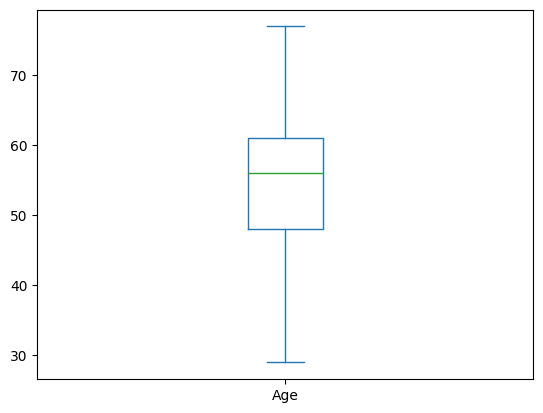

In [568]:
df['Age'].plot(kind='box')

<Axes: xlabel='Age', ylabel='Chol'>

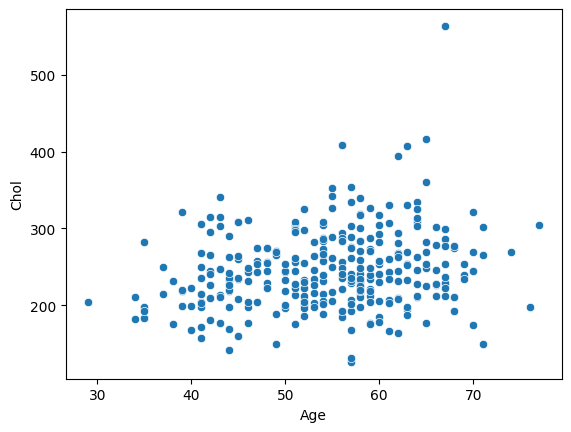

In [569]:
sns.scatterplot(data=df, x=df["Age"], y=df["Chol"])

<Axes: xlabel='Age', ylabel='Chol'>

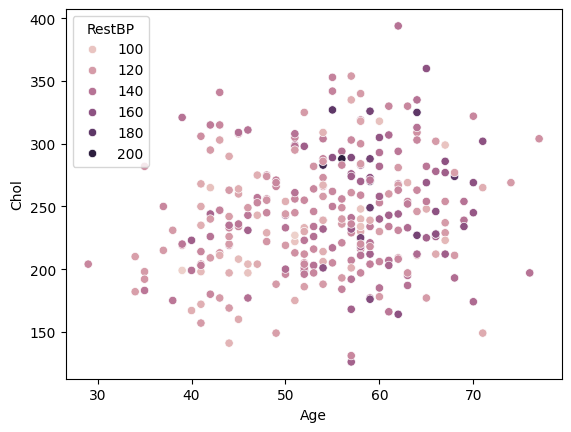

In [570]:
df_low_chol = df[df['Chol'] < 400]
sns.scatterplot(data=df, x=df_low_chol["Age"], y=df_low_chol["Chol"], hue=df['RestBP'])

<Axes: xlabel='Age', ylabel='Chol'>

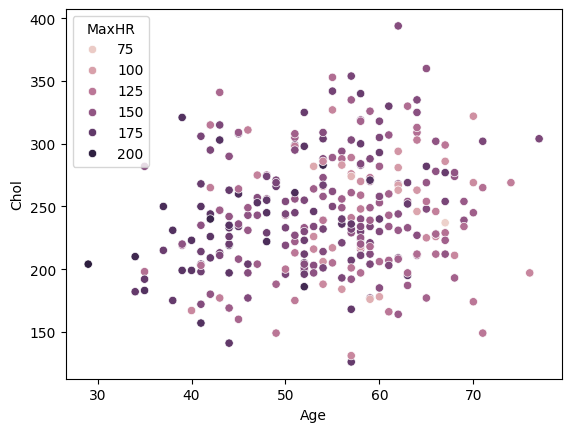

In [571]:
sns.scatterplot(data=df, x=df_low_chol["Age"], y=df_low_chol["Chol"], hue=df['MaxHR'])

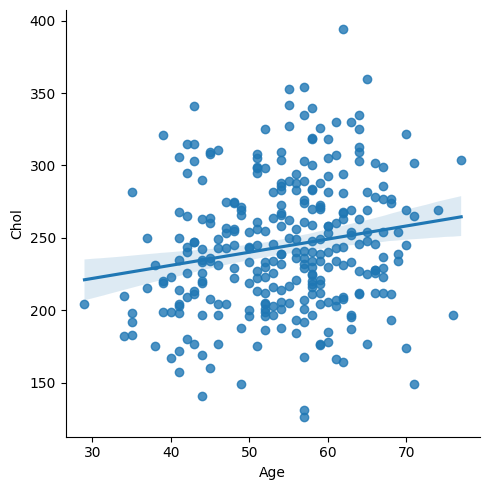

In [572]:
sns.lmplot(data=df_low_chol, x="Age", y="Chol")

## Encoding

In [573]:
df.info()
df_enc = pd.get_dummies(df, columns=['ChestPain', 'Thal'], dtype='int')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         303 non-null    int64  
 12  Thal       303 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [574]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     303 non-null    int64  
 1   Sex                     303 non-null    int64  
 2   RestBP                  303 non-null    int64  
 3   Chol                    303 non-null    int64  
 4   Fbs                     303 non-null    int64  
 5   RestECG                 303 non-null    int64  
 6   MaxHR                   303 non-null    int64  
 7   ExAng                   303 non-null    int64  
 8   Oldpeak                 303 non-null    float64
 9   Slope                   303 non-null    int64  
 10  Ca                      303 non-null    int64  
 11  AHD                     303 non-null    object 
 12  ChestPain_asymptomatic  303 non-null    int64  
 13  ChestPain_nonanginal    303 non-null    int64  
 14  ChestPain_nontypical    303 non-null    in

In [575]:
df_enc["AHD"] = df_enc['AHD'].map({'Yes': 1, 'No': 0})
df_enc.shape

(303, 19)

## Train/Test Split

In [576]:
X = df_enc.drop(columns='AHD', axis=1)
y = df_enc['AHD']

In [577]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Perform SVM (SVC)

Support Vector Classifier

[Ref](https://datatron.com/what-is-a-support-vector-machine)

![SVM](https://datatron.com/wp-content/uploads/2021/05/Support-Vector-Machine.png)

In [578]:
SVG_Model = svm.SVC()

param_grid = {
  'C': [1, 10, 100, 1000, 2000],
  'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
  'kernel': ['rbf', 'sigmoid']
}

In [579]:
# Deploy our GS
GS = GridSearchCV(SVG_Model, param_grid, cv=20, verbose=1)
GS_Model = GS.fit(X_train, y_train)

Fitting 20 folds for each of 60 candidates, totalling 1200 fits


In [580]:
GS_Model.best_params_

{'C': 2000, 'gamma': 1e-05, 'kernel': 'rbf'}

In [581]:
accuracy = GS_Model.best_score_
accuracy

0.8227564102564104

In [582]:
y_test_pred = GS_Model.predict(X_test)

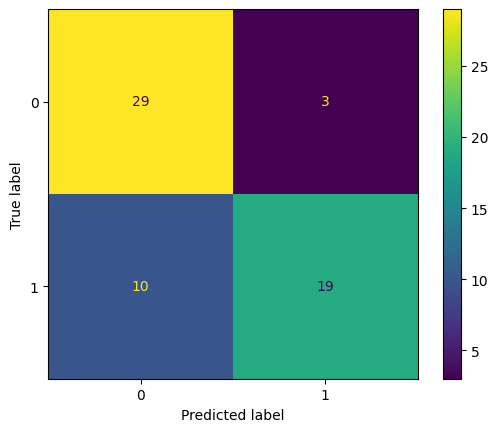

In [583]:
CM = confusion_matrix(y_test, y_test_pred)
CM_display = ConfusionMatrixDisplay(confusion_matrix=CM)
CM_display.plot()

- After running another round of hyper parameter tuning, we got much better results
- There are 12 cases where the model mis-classified "Yes" for heart disease where it was "No"
- We want this number to be as small as possible to make sure the patient predicted to have heart disease get proper medical attention

In [584]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82        32
           1       0.86      0.66      0.75        29

    accuracy                           0.79        61
   macro avg       0.80      0.78      0.78        61
weighted avg       0.80      0.79      0.78        61



- `precision` reflects how the model correctly predicted positive observations from total predicted positives
- `recall` reflects
- `f1-score` is the hermonic mean between `precision` and `recall`